In [1]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Activation, 
                                     MaxPooling2D, Concatenate, Flatten, Dense, Add, 
                                     AveragePooling2D, Dropout)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from sklearn.metrics import (confusion_matrix, roc_curve, auc, 
                             precision_score, recall_score, classification_report)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import copy
from copy import deepcopy
from collections import deque
import math
import time

import torch
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries


from PIL import Image
import torchvision.transforms as T

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

2025-12-18 20:24:50.828063: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766089491.279931      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766089491.405803      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 1.1 Global Configuration

In [2]:
DEFAULT_HYPERPARAMS = {
    "input_shape": (224, 224, 3),
    "num_classes": 3,
    "learning_rate": 0.0001,
    "epochs": 50,
    "batch_size": 16
}

BASE_PATH = "/kaggle/input/feature-selelcted-dataset"
CATEGORIES = ['normal', 'covid19', 'pneumonia']
IMAGE_SIZE = (DEFAULT_HYPERPARAMS['input_shape'][0], DEFAULT_HYPERPARAMS['input_shape'][1])
LABEL_MAPPING = {'covid19': 0, 'pneumonia': 1, 'normal': 2}
TARGET_NAMES = ['Covid-19', 'Pneumonia', 'Normal']

optimization_summary = {}

# 1. Data Loading and Preprocessing

In [3]:
def load_images(folder, categories, image_size):
    
    images, labels = [], []
    for category in categories:
        category_path = os.path.join(folder, category)
        if not os.path.isdir(category_path):
            print(f"Warning: Directory not found: {category_path}")
            continue
            
        for filename in os.listdir(category_path):
            img_path = os.path.join(category_path, filename)
            try:
                img = cv2.imread(img_path)  # Load in BGR
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
                    img = cv2.resize(img, image_size)
                    images.append(img)
                    labels.append(category)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
                
    return np.array(images).astype('float32'), np.array(labels)

In [4]:
def load_image_as_tensor(image_path, device='cpu'):
    """
    Load an image from path and convert to torch.Tensor (C,H,W) in [0,1].
    """
    img = Image.open(image_path).convert("RGB")  # ensure 3 channels
    transform = T.Compose([
        T.Resize((224, 224)),      # resize if your model expects fixed input
        T.ToTensor(),              # converts to [0,1] tensor CxHxW
    ])
    x_tensor = transform(img).to(device)
    return x_tensor



In [5]:
def encode_labels(labels, label_mapping, num_classes):
    int_labels = [label_mapping[label] for label in labels]
    return tf.keras.utils.to_categorical(int_labels, num_classes=num_classes).astype('float32')

train_images, train_labels_raw = load_images(
    os.path.join(BASE_PATH, 'train'), CATEGORIES, IMAGE_SIZE
)
test_images_full, test_labels_full_raw = load_images(
    os.path.join(BASE_PATH, 'test'), CATEGORIES, IMAGE_SIZE
)

val_images, test_images, val_labels_raw, test_labels_raw = train_test_split(
    test_images_full, test_labels_full_raw, 
    test_size=0.75, 
    stratify=test_labels_full_raw, 
    random_state=42
)

train_labels = encode_labels(train_labels_raw, LABEL_MAPPING, DEFAULT_HYPERPARAMS['num_classes'])
val_labels = encode_labels(val_labels_raw, LABEL_MAPPING, DEFAULT_HYPERPARAMS['num_classes'])
test_labels = encode_labels(test_labels_raw, LABEL_MAPPING, DEFAULT_HYPERPARAMS['num_classes'])

print(f"Train images shape: {train_images.shape}")
print(f"Validation images shape: {val_images.shape}")
print(f"Test images shape: {test_images.shape}")

Train images shape: (1205, 224, 224, 3)
Validation images shape: (75, 224, 224, 3)
Test images shape: (227, 224, 224, 3)


# 2. Data Augmentation & Generators

## 2.1 Create Data Generators

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow(
    x=train_images,
    y=train_labels,
    batch_size=DEFAULT_HYPERPARAMS['batch_size'],
    shuffle=True
)

validation_generator = val_test_datagen.flow(
    x=val_images,
    y=val_labels,
    batch_size=DEFAULT_HYPERPARAMS['batch_size'],
    shuffle=True
)

test_generator = val_test_datagen.flow(
    x=test_images,
    y=test_labels,
    batch_size=DEFAULT_HYPERPARAMS['batch_size'],
    shuffle=False
)

In [7]:
steps_per_epoch = math.ceil(len(train_images) / DEFAULT_HYPERPARAMS['batch_size'])
validation_steps = math.ceil(len(val_images) / DEFAULT_HYPERPARAMS['batch_size'])
test_steps = math.ceil(len(test_images) / DEFAULT_HYPERPARAMS['batch_size'])

# 3. Core Helper Functions (Model & Evaluation)

In [8]:
def build_vgg16_model(input_shape, num_classes, dropout_rate, learning_rate, dense_units):
    """
    Creates the VGG16 model with a custom hyperparameterized classification head.
    This function is used by all optimization algorithms.
    """
    inputs = tf.keras.Input(shape=input_shape, name='input_1')
    weights = 'imagenet'
    weights_path = os.path.expanduser('~/.keras/models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
    if os.path.exists(weights_path):
        weights = weights_path

    base_model = VGG16(weights=weights, include_top=False, input_tensor=inputs)
    base_model.trainable = False

    layer_name_mapping = {
        'block1_conv1': 'Glock1_conv1', 'block1_conv2': 'Glock1_conv2', 'block1_pool': 'Glock1_pool',
        'block2_conv1': 'Glock2_conv1', 'block2_conv2': 'Glock2_conv2', 'block2_pool': 'Glock2_coel',
        'block3_conv1': 'Glock3_conv1', 'block3_conv2': 'Glock3_conv2', 'block3_conv3': 'Glock3_conv3', 'block3_pool': 'Glock3_coel',
        'block4_conv1': 'Glock4_conv1', 'block4_conv2': 'Glock4_conv2', 'block4_conv3': 'Glock4_conv3', 'block4_pool': 'Glock4_coel',
        'block5_conv1': 'Glock5_conv1', 'block5_conv2': 'Glock5_conv2', 'block5_conv3': 'Glock5_conv3', 'block5_pool': 'Glock5_coel'
    }
    for layer in base_model.layers:
        if layer.name in layer_name_mapping:
            layer._name = layer_name_mapping[layer.name]
    
    x = base_model.output
    x = AveragePooling2D(pool_size=(4, 4), name='Avarage_poolZhg8')(x)
    x = Flatten(name='Atsitas')(x)
    
    x = Dense(dense_units, activation='relu', name='Aonte')(x)
    
    x = Dropout(dropout_rate, name='Argoat_dropout')(x)
    outputs = Dense(num_classes, activation='softmax', name='Gonsu_2_softmax')(x)

    model = Model(inputs=inputs, outputs=outputs, name='nCOVnet_Optimized')

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [9]:
def plot_training_history(history, title="Model Training History"):
    """
    Plots accuracy and loss curves for a given Keras history object.
    Returns the max validation accuracy and min validation loss.
    """
    plt.figure(figsize=(12, 5))
    
    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy - {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss - {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    max_val_acc = max(history.history['val_accuracy'])
    min_val_loss = min(history.history['val_loss'])
    return max_val_acc, min_val_loss

In [10]:
def evaluate_model(model, test_generator, target_names, title="Model Evaluation"):

    print(f"\n--- {title} ---")
    
    # 0. Evaluate model for loss and accuracy
    test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps, verbose=0)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    
    # 1. Make predictions
    y_pred_probs = model.predict(test_generator, steps=test_steps)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    # 2. Get true labels
    # We use test_generator.y which we know is not shuffled
    y_true = np.argmax(test_generator.y, axis=1)
    
    # 3. Print Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=target_names))

    # 4. Calculate Sensitivity and Specificity
    cm = confusion_matrix(y_true, y_pred)
    sensitivities, specificities = [], []
    for i in range(len(cm)):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FN + FP)
        
        sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
        sensitivities.append(sensitivity)
        specificities.append(specificity)

    overall_sensitivity = np.mean(sensitivities)
    overall_specificity = np.mean(specificities)
    
    print(f"Overall Sensitivity (macro-averaged) = {overall_sensitivity:.4f}")
    print(f"Overall Specificity (macro-averaged) = {overall_specificity:.4f}")

    # 5. Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, 
                yticklabels=target_names)
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # 6. Plot ROC Curve (One vs Rest)
    fpr, tpr, roc_auc = {}, {}, {}
    n_classes = len(target_names)
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(test_generator.y[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve ({target_names[i]}) (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) - {title}')
    plt.legend(loc='lower right')
    plt.show()
    
    return test_loss, test_accuracy, overall_sensitivity, overall_specificity

# Final Model

In [11]:
print("\n--- Final VGG16 (SA) Model Training ---")

dense_units = 256
drop_out = 0
final_model = build_vgg16_model(
    DEFAULT_HYPERPARAMS['input_shape'],
    DEFAULT_HYPERPARAMS['num_classes'],
    drop_out, 
    DEFAULT_HYPERPARAMS['learning_rate'], 
    dense_units
)

print(f"Training VGG16 (SA) model for {DEFAULT_HYPERPARAMS['epochs']} epochs with optimal HPs:")
print(f"LR: {DEFAULT_HYPERPARAMS['learning_rate']:.6f}, Dropout: {drop_out:.4f}, Dense: {dense_units}")
print(f"Using Generator Batch Size: {DEFAULT_HYPERPARAMS['batch_size']}")


--- Final VGG16 (SA) Model Training ---


I0000 00:00:1766089536.413765      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766089536.414388      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training VGG16 (SA) model for 50 epochs with optimal HPs:
LR: 0.000100, Dropout: 0.0000, Dense: 256
Using Generator Batch Size: 16


In [12]:
final_model.summary()

Model: "nCOVnet_Optimized"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_1 (InputLayer)            │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Avarage_poolZhg8                │ (None, 1, 1, 512)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Atsitas (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Aonte (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Argoat_dropout (Dropout)        │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Gonsu_2_softmax (Dense)         │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 14,846,787 (56.64 MB)

 Trainable params: 132,099 (516.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [13]:
hc_train_start_time = time.time()
history_final = final_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=DEFAULT_HYPERPARAMS['epochs'],
    validation_data=validation_generator,
    validation_steps=validation_steps,
    verbose=1 
)
hc_train_time = time.time() - hc_train_start_time
print(f"--- HC (RS) Final Training Finished in {hc_train_time:.2f} seconds ---")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1766089541.639148     103 service.cc:148] XLA service 0x7a561800ffd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766089541.641239     103 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1766089541.641270     103 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1766089542.097672     103 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/76 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.4219 - loss: 1.1223  

I0000 00:00:1766089549.950600     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


76/76 ━━━━━━━━━━━━━━━━━━━━ 31s 274ms/step - accuracy: 0.3846 - loss: 1.1065 - val_accuracy: 0.6533 - val_loss: 0.9914
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 164ms/step - accuracy: 0.6560 - loss: 0.9484 - val_accuracy: 0.6533 - val_loss: 0.8793
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 170ms/step - accuracy: 0.6517 - loss: 0.8675 - val_accuracy: 0.6267 - val_loss: 0.8096
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 173ms/step - accuracy: 0.6931 - loss: 0.7902 - val_accuracy: 0.6667 - val_loss: 0.7553
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 166ms/step - accuracy: 0.7053 - loss: 0.7318 - val_accuracy: 0.6800 - val_loss: 0.7166
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 167ms/step - accuracy: 0.7221 - loss: 0.6893 - val_accuracy: 0.6533 - val_loss: 0.6860
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 163ms/step - accuracy: 0.7106 - loss: 0.6769 - val_accuracy: 0.6533 - val_loss: 0.6671
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 160ms/step - accuracy: 0.6905 - loss: 0.6625 - val_accuracy: 0.693

# GRADCAM Explanation


In [15]:
import matplotlib.cm as cm

def compute_gradcam_tf(model, x, target_class, target_layer_name):

    x_input = tf.expand_dims(x, axis=0)  

    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(target_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(x_input)
        loss = predictions[:, target_class]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_sum(tf.multiply(conv_outputs, pooled_grads), axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    if tf.reduce_max(heatmap) != 0:
        heatmap /= tf.reduce_max(heatmap)
        
    return heatmap.numpy()

## Helper Function

In [16]:
def scale_region_to_heatmap(region, input_shape, heatmap_shape):
    x1, y1, x2, y2 = region
    H_in, W_in = input_shape[:2]
    H_hm, W_hm = heatmap_shape[:2]
    
    x1_s = int(x1 / W_in * W_hm)
    x2_s = int(x2 / W_in * W_hm)
    y1_s = int(y1 / H_in * H_hm)
    y2_s = int(y2 / H_in * H_hm)
    return (x1_s, y1_s, x2_s, y2_s)



In [17]:
def apply_region_vector_to_image(x_original, region, vector):
    x_mod = x_original.copy()
    x1, y1, x2, y2 = region
    H, W = y2 - y1, x2 - x1
    C = x_original.shape[2]
    
    vector_reshaped = vector.reshape(H, W, C)
    x_mod[y1:y2, x1:x2, :] += vector_reshaped
    x_mod = np.clip(x_mod, 0, 1)
    return x_mod

In [18]:
def gradcam_region_score_tf(model, x_original, vector, region, target_class, target_layer_name):
    modified = apply_region_vector_to_image(x_original, region, vector)
    heatmap = compute_gradcam_tf(model, modified, target_class, target_layer_name)
    
    scaled_region = scale_region_to_heatmap(region, x_original.shape, heatmap.shape)
    x1, y1, x2, y2 = scaled_region
    region_map = heatmap[y1:y2, x1:x2]
    return np.sum(region_map)

In [ ]:
def superimpose_heatmap(original_img, heatmap, alpha=0.4):

    img_h, img_w = original_img.shape[:2]
    
    heatmap_expanded = heatmap[..., np.newaxis] 
    
    heatmap_resized = tf.image.resize(heatmap_expanded, (img_h, img_w), method='bilinear')
    heatmap_resized = heatmap_resized.numpy().squeeze()
    
    heatmap_resized = np.maximum(heatmap_resized, 0)
    if np.max(heatmap_resized) != 0:
        heatmap_resized /= np.max(heatmap_resized)
    jet = cm.get_cmap("jet")
    heatmap_rgb = jet(heatmap_resized)[..., :3] 
    superimposed_img = original_img + heatmap_rgb * alpha
    
    superimposed_img = np.clip(superimposed_img / np.max(superimposed_img), 0, 1)
    
    return superimposed_img


## Grey Wolf Optimization

In [50]:
def optimize_gradcam_region_gwo_tf(
        model, 
        x_original, 
        target_class, 
        region, 
        target_layer_name='block5_conv3', 
        population_size=5, 
        max_iterations=12, 
        init_perturb=0.05,
        random_seed=42
    ):
    np.random.seed(random_seed)
    H, W = region[3]-region[1], region[2]-region[0]
    C = x_original.shape[2]
    vec_dim = H*W*C

    wolves = np.random.normal(0, init_perturb, size=(population_size, vec_dim))
    scores = [gradcam_region_score_tf(model, x_original, w, region, target_class, target_layer_name) 
              for w in wolves]

    alpha_idx = np.argmax(scores)
    alpha_score = scores[alpha_idx]
    alpha_wolf = wolves[alpha_idx].copy()

    history = [alpha_score]

    print(f"Starting Optimization... (Layer: {target_layer_name})")
    for iteration in range(max_iterations):
        a = 2 * (1 - iteration / max_iterations)
        
        for i in range(population_size):
            r1, r2 = np.random.rand(2)
            A = 2 * a * r1 - a
            C_coeff = 2 * r2
            
            # GWO update equation
            D_alpha = np.abs(C_coeff * alpha_wolf - wolves[i])
            wolves[i] = alpha_wolf - A * D_alpha + np.random.normal(0, init_perturb, vec_dim)
            wolves[i] = np.clip(wolves[i], -0.5, 0.5)

            # Evaluate
            scores[i] = gradcam_region_score_tf(model, x_original, wolves[i], region, target_class, target_layer_name)

        max_idx = np.argmax(scores)
        if scores[max_idx] > alpha_score:
            alpha_score = scores[max_idx]
            alpha_wolf = wolves[max_idx].copy()

        history.append(alpha_score)
        print(f"Iteration {iteration+1}/{max_iterations} - Best Score = {alpha_score:.4f}")

    best_img = apply_region_vector_to_image(x_original, region, alpha_wolf)
    return best_img, alpha_score, history


## Whale Optimization

In [20]:
def optimize_gradcam_region_woa_tf(
        model, 
        x_original, 
        target_class, 
        region, 
        target_layer_name='block5_conv3', 
        num_whales=5, 
        max_iterations=12, 
        init_perturb=0.05,
        random_seed=42
    ):
    np.random.seed(random_seed)

    H, W = region[3] - region[1], region[2] - region[0]
    C = x_original.shape[2]
    dim = H * W * C

    lb, ub = -0.5, 0.5

    whales = np.random.normal(0, init_perturb, size=(num_whales, dim))
    whales = np.clip(whales, lb, ub)

    fitness = np.array([
        gradcam_region_score_tf(
            model, x_original, w, region, target_class, target_layer_name
        ) for w in whales
    ])

    best_idx = np.argmax(fitness)
    X_best = whales[best_idx].copy()
    F_best = fitness[best_idx]

    history = [F_best]


    for t in range(max_iterations):
        a = 2 - t * (2 / max_iterations)

        for i in range(num_whales):
            r1 = np.random.rand(dim)
            r2 = np.random.rand(dim)

            A = 2 * a * r1 - a
            C_coeff = 2 * r2
            p = np.random.rand()
            l = np.random.uniform(-1, 1)
            b = 1

            if p < 0.5:
                if np.all(np.abs(A) < 1):
                    # Encircling best
                    D = np.abs(C_coeff * X_best - whales[i])
                    whales[i] = X_best - A * D
                else:
                    # Search random whale
                    rand_idx = np.random.randint(num_whales)
                    X_rand = whales[rand_idx]
                    D = np.abs(C_coeff * X_rand - whales[i])
                    whales[i] = X_rand - A * D
            else:
                D = np.abs(X_best - whales[i])
                whales[i] = (
                    D * np.exp(b * l) * np.cos(2 * np.pi * l)
                    + X_best
                )

            whales[i] += np.random.normal(0, init_perturb, dim)
            whales[i] = np.clip(whales[i], lb, ub)

        fitness = np.array([
            gradcam_region_score_tf(
                model, x_original, w, region, target_class, target_layer_name
            ) for w in whales
        ])

        best_idx = np.argmax(fitness)
        if fitness[best_idx] > F_best:
            X_best = whales[best_idx].copy()
            F_best = fitness[best_idx]

        history.append(F_best)
        print(f"Iteration {t+1}/{max_iterations} - Best Score = {F_best:.4f}")

    best_img = apply_region_vector_to_image(x_original, region, X_best)
    return best_img, F_best, history


## Firefly Optimization

In [39]:
def optimize_gradcam_region_firefly_tf(
        model,
        x_original,
        target_class,
        region,
        target_layer_name='block5_conv3',
        n_fireflies=6,
        max_iterations=12,
        alpha=0.25,
        beta0=1.0,
        gamma=1.0,
        init_perturb=0.05,
        random_seed=42
    ):
    np.random.seed(random_seed)

    H, W = region[3] - region[1], region[2] - region[0]
    C = x_original.shape[2]
    dim = H * W * C

    lb, ub = -0.5, 0.5

    fireflies = np.random.normal(0, init_perturb, size=(n_fireflies, dim))
    fireflies = np.clip(fireflies, lb, ub)

    fitness = np.array([
        gradcam_region_score_tf(
            model, x_original, f, region, target_class, target_layer_name
        ) for f in fireflies
    ])

    best_idx = np.argmax(fitness)
    X_best = fireflies[best_idx].copy()
    F_best = fitness[best_idx]

    history = [F_best]


    def distance(a, b):
        return np.linalg.norm(a - b)

    for iteration in range(max_iterations):
        print(f"Iteration {iteration+1}/{max_iterations}")

        for i in range(n_fireflies):
            for j in range(n_fireflies):
                if fitness[j] > fitness[i]:
                    r = distance(fireflies[i], fireflies[j])
                    beta = beta0 * np.exp(-gamma * r * r)
                    eps = np.random.rand(dim) - 0.5

                    move = (
                        beta * (fireflies[j] - fireflies[i])
                        + alpha * eps
                    )

                    fireflies[i] += move
                    fireflies[i] = np.clip(fireflies[i], lb, ub)

                    # Re-evaluate moved firefly
                    fitness[i] = gradcam_region_score_tf(
                        model, x_original, fireflies[i],
                        region, target_class, target_layer_name
                    )

        # Update global best
        best_idx = np.argmax(fitness)
        if fitness[best_idx] > F_best:
            X_best = fireflies[best_idx].copy()
            F_best = fitness[best_idx]

        history.append(F_best)
        print(f"  Best Score = {F_best:.4f}")

        alpha *= 0.95  # reduce randomness

    best_img = apply_region_vector_to_image(x_original, region, X_best)
    return best_img, F_best, history


## Visualize

In [30]:
def visualize_gradcam_on_image(model, x_orig, x_opt, target_class, target_layer='block5_conv3'):
    hm_orig = compute_gradcam_tf(model, x_orig, target_class, target_layer)
    hm_opt  = compute_gradcam_tf(model, x_opt, target_class, target_layer)

    cam_orig = superimpose_heatmap(x_orig, hm_orig, alpha=0.4)
    cam_opt  = superimpose_heatmap(x_opt, hm_opt, alpha=0.4)

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(cam_orig)
    plt.title("Grad-CAM Before")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cam_opt)
    plt.title("Grad-CAM After")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [53]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

img_path = "/kaggle/input/feature-selelcted-dataset/test/covid19/image_195.png"

original_pil = load_img(img_path, target_size=(224, 224)) 
x_orig = img_to_array(original_pil)
x_orig = x_orig / 255.0 

preds = final_model.predict(np.expand_dims(x_orig, axis=0))
target_class = np.argmax(preds[0])
print(f"Target Class Index: {target_class}")

region = (50, 50, 150, 150) 

best_img_tf, best_score, history = optimize_gradcam_region_gwo_tf(
    model=final_model,
    x_original=x_orig,
    target_class=target_class,
    region=region,
    target_layer_name='block5_conv3',  
    population_size=10,
    max_iterations=50,
    init_perturb=0.05
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Target Class Index: 1
Starting Optimization... (Layer: block5_conv3)
Iteration 1/50 - Best Score = 18.8103
Iteration 2/50 - Best Score = 19.1171
Iteration 3/50 - Best Score = 19.1171
Iteration 4/50 - Best Score = 19.7955
Iteration 5/50 - Best Score = 19.7955
Iteration 6/50 - Best Score = 19.7955
Iteration 7/50 - Best Score = 19.7955
Iteration 8/50 - Best Score = 19.8180
Iteration 9/50 - Best Score = 19.8180
Iteration 10/50 - Best Score = 19.8180
Iteration 11/50 - Best Score = 19.8180
Iteration 12/50 - Best Score = 19.8180
Iteration 13/50 - Best Score = 19.8180
Iteration 14/50 - Best Score = 19.8180
Iteration 15/50 - Best Score = 19.8180
Iteration 16/50 - Best Score = 19.8180
Iteration 17/50 - Best Score = 19.8180
Iteration 18/50 - Best Score = 20.9741
Iteration 19/50 - Best Score = 20.9741
Iteration 20/50 - Best Score = 20.9741
Iteration 21/50 - Best Score = 20.9741
Iteration 22/50 - Best Score = 20.9741
Iteration 23/50 - Best Score = 20.9741
Itera

/tmp/ipykernel_38/4070005359.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


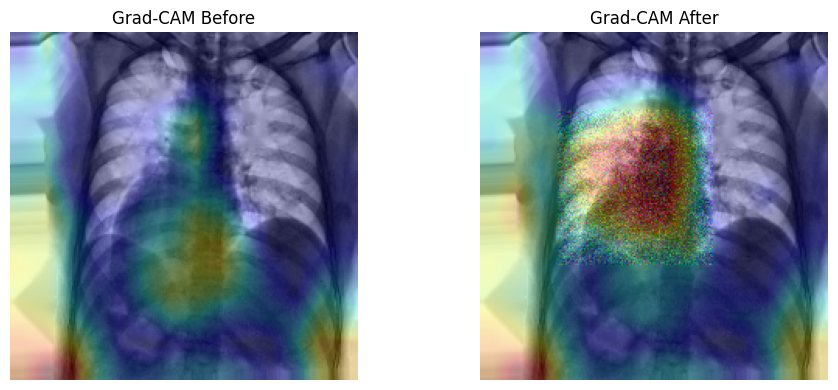

In [54]:
visualize_gradcam_on_image(
    model=final_model,
    x_orig=x_orig,
    x_opt=best_img_tf,
    target_class=target_class,
    target_layer='block5_conv3'
)


In [45]:
best_img_tf, best_score, history = optimize_gradcam_region_woa_tf(
    model=final_model,
    x_original=x_orig,
    target_class=target_class,
    region=region,
    target_layer_name='block5_conv3',
    num_whales=10,
    max_iterations=50,
    init_perturb=0.05
)


Starting Whale Optimization... (Layer: block5_conv3)
Iteration 1/50 - Best Score = 19.1509
Iteration 2/50 - Best Score = 19.9003
Iteration 3/50 - Best Score = 19.9003
Iteration 4/50 - Best Score = 19.9003
Iteration 5/50 - Best Score = 19.9003
Iteration 6/50 - Best Score = 19.9003
Iteration 7/50 - Best Score = 19.9003
Iteration 8/50 - Best Score = 19.9003
Iteration 9/50 - Best Score = 19.9003
Iteration 10/50 - Best Score = 19.9003
Iteration 11/50 - Best Score = 19.9003
Iteration 12/50 - Best Score = 19.9003
Iteration 13/50 - Best Score = 19.9003
Iteration 14/50 - Best Score = 19.9003
Iteration 15/50 - Best Score = 19.9003
Iteration 16/50 - Best Score = 20.1683
Iteration 17/50 - Best Score = 20.1683
Iteration 18/50 - Best Score = 20.1683
Iteration 19/50 - Best Score = 20.1683
Iteration 20/50 - Best Score = 20.1683
Iteration 21/50 - Best Score = 20.1683
Iteration 22/50 - Best Score = 20.2928
Iteration 23/50 - Best Score = 20.2928
Iteration 24/50 - Best Score = 20.2928
Iteration 25/50 - Be

/tmp/ipykernel_38/4070005359.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


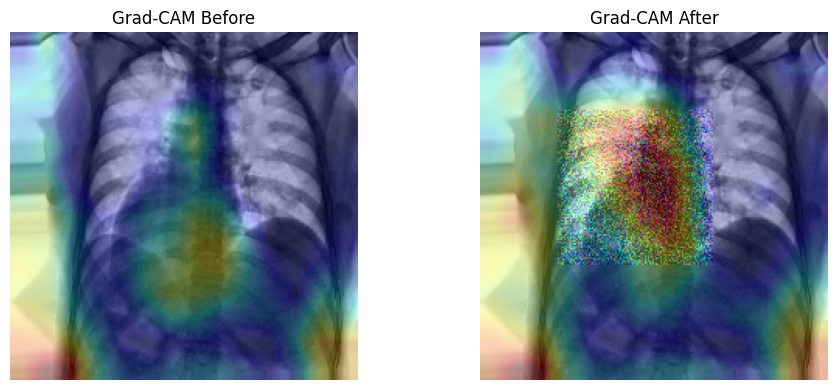

In [47]:
visualize_gradcam_on_image(
    model=final_model,
    x_orig=x_orig,
    x_opt=best_img_tf,
    target_class=target_class,
    target_layer='block5_conv3'
)


In [48]:
best_img_ff, best_score_ff, history_ff = optimize_gradcam_region_firefly_tf(
    model=final_model,
    x_original=x_orig,
    target_class=target_class,
    region=region,
    target_layer_name='block5_conv3',
     n_fireflies=10,
     max_iterations=50
)


Starting Firefly Optimization... (Layer: block5_conv3)
Iteration 1/50
  Best Score = 18.0801
Iteration 2/50
  Best Score = 18.7411
Iteration 3/50
  Best Score = 18.7411
Iteration 4/50
  Best Score = 18.7411
Iteration 5/50
  Best Score = 18.7411
Iteration 6/50
  Best Score = 18.7411
Iteration 7/50
  Best Score = 18.7411
Iteration 8/50
  Best Score = 18.7411
Iteration 9/50
  Best Score = 18.7411
Iteration 10/50
  Best Score = 18.7411
Iteration 11/50
  Best Score = 18.7411
Iteration 12/50
  Best Score = 18.7411
Iteration 13/50
  Best Score = 18.7411
Iteration 14/50
  Best Score = 18.7411
Iteration 15/50
  Best Score = 18.7411
Iteration 16/50
  Best Score = 18.7411
Iteration 17/50
  Best Score = 18.7411
Iteration 18/50
  Best Score = 18.7411
Iteration 19/50
  Best Score = 18.7411
Iteration 20/50
  Best Score = 18.7411
Iteration 21/50
  Best Score = 18.7411
Iteration 22/50
  Best Score = 18.7411
Iteration 23/50
  Best Score = 18.7411
Iteration 24/50
  Best Score = 18.7411
Iteration 25/50
  

/tmp/ipykernel_38/4070005359.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


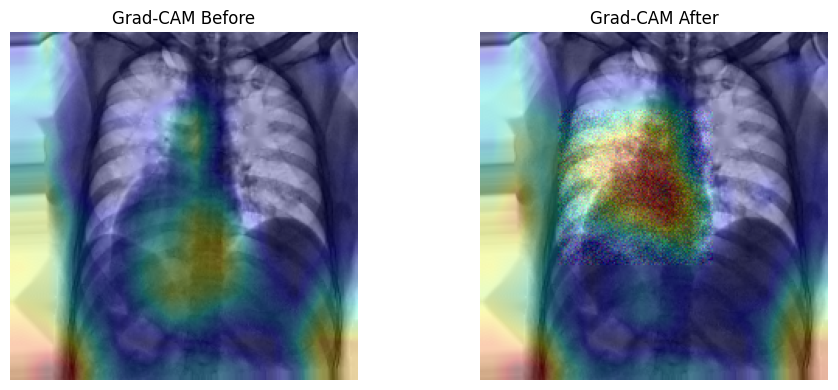

In [49]:
visualize_gradcam_on_image(
    final_model, x_orig, best_img_ff,
    target_class, target_layer='block5_conv3'
)
